<img src="https://i1.sndcdn.com/avatars-000274765548-vj7h0w-t500x500.jpg" style='float:right; width:200px; margin: 0 20px;'>

<img src="https://cdn2.iconfinder.com/data/icons/popular-social-media-flat/48/Popular_Social_Media-11-512.png" style='float:right; width:200px; margin: 0 20px;'>


# Twitter V CMV topological differences --> Twitter
---

> Create feature set for CMV and Twitter 

> Do comperative analysis of features

In [ ]:
# env 
import sys
sys.path.append('/Users/shaimeital/code/thesis/conversant')
sys.path.append('/Users/shaimeital/code/thesis/cmv-stance-classification')


In [66]:
from typing import Iterable, List, Sequence, Set
import json

import pandas as pd
import numpy as np
import networkx as nx
import glob
import os

import logging
logging.basicConfig()
logging.getLogger().setLevel(logging.INFO)

In [2]:
from conversant.conversation.examples.controversial_feature_extraction import *
from conversant.conversation\
    .conversation_utils import conversation_to_dataframe
from stance_classification.twitter_conversation_parser import TwitterConversationReader

from stance_classification.classifiers.maxcut_stance_classifier import MaxcutStanceClassifier

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

## Load Raw Data

In [4]:
twitter_conversations_path = r"C:\Users\ronp\Documents\stance-classification\rumors_dataset\PHEME_veracity\full-conversations"
# twitter_conversations_path = "/Users/shaimeital/code/thesis/cmv-stance-classification/data/Twitter Conversation/rumers/full-conversations"
twitter_conversation_ids = [file for file in os.listdir(twitter_conversations_path)]

In [5]:
# one example
conv_id = "498235547685756928"
conversation_path = os.path.join(twitter_conversations_path, conv_id, "tweets.jsonl")
sample = pd.read_json(conversation_path,
                     lines= True,
                     dtype={'in_reply_to_status_id_str':str, 'conversation_id_str': str, 'full_text':str, 'id_str':str})
sample

INFO:numexpr.utils:NumExpr defaulting to 4 threads.


,created_at,id_str,full_text,display_text_range,entities,extended_entities,source,in_reply_to_status_id_str,in_reply_to_user_id_str,in_reply_to_screen_name,user_id_str,retweet_count,favorite_count,reply_count,quote_count,conversation_id_str,possibly_sensitive_editable,lang
0,2014-08-10 00:32:13+00:00,498265524397432832,@annaxsweat http://t.co/Z7Qm4iaoSR,"[0, 34]",{'user_mentions': [{'screen_name': 'annaxsweat...,"{'media': [{'id_str': '498265523889930242', 'i...","<a href=""http://twitter.com/#!/download/ipad"" ...",498235547685756928,1.539100e+09,annaxsweat,21461995,2,1,0,0,498235547685756928,1.0,und
1,2014-08-10 00:37:23+00:00,498266827676741632,@annaxsweat #StopThugCops We have to take acti...,"[0, 81]","{'hashtags': [{'text': 'StopThugCops', 'indice...",NaN,"<a href=""http://twitter.com/#!/download/ipad"" ...",498235547685756928,1.539100e+09,annaxsweat,21461995,4,2,0,0,498235547685756928,NaN,en
2,2014-08-11 05:58:51+00:00,498710112358244352,@annaxsweat 18*,"[0, 15]",{'user_mentions': [{'screen_name': 'annaxsweat...,NaN,"<a href=""http://twitter.com"" rel=""nofollow"">Tw...",498235547685756928,1.539100e+09,annaxsweat,481509183,0,0,1,0,498235547685756928,NaN,und
3,2014-08-10 17:21:03+00:00,498519407375941632,@annaxsweat: Soooo wonderfully said! Thank you...,"[0, 73]",{'user_mentions': [{'screen_name': 'annaxsweat...,NaN,"<a href=""http://twitter.com"" rel=""nofollow"">Tw...",498235547685756928,1.539100e+09,annaxsweat,2331498373,0,0,0,0,498235547685756928,NaN,en
4,2014-08-10 03:40:28+00:00,498312902928244736,"@annaxsweat well, he damn sure ain't a child","[0, 44]",{'user_mentions': [{'screen_name': 'annaxsweat...,NaN,"<a href=""http://twitter.com"" rel=""nofollow"">Tw...",498235547685756928,1.539100e+09,annaxsweat,2437571275,0,1,1,0,498235547685756928,NaN,en
5,2014-08-10 03:42:21+00:00,498313376888799232,@HighPlainsCoot fuck. Off.,"[0, 26]",{},NaN,"<a href=""http://twitter.com/download/iphone"" r...",498312902928244736,2.437571e+09,HighPlainsRover,1539100118,0,0,2,0,498235547685756928,NaN,en
6,2014-08-11 10:58:25+00:00,498785502062190592,@AlexisAStevens yeah that tweet was written be...,"[0, 101]",{},NaN,"<a href=""http://twitter.com/download/iphone"" r...",498710112358244352,4.815092e+08,AlexisAurora_,1539100118,0,0,0,0,498235547685756928,NaN,en
7,2014-08-11 15:15:42+00:00,498850250048946176,@annaxsweat after several hours someone noticed,"[0, 47]",{'user_mentions': [{'screen_name': 'annaxsweat...,NaN,"<a href=""http://www.tweetcaster.com"" rel=""nofo...",498235547685756928,1.539100e+09,annaxsweat,2556027474,0,0,0,0,498235547685756928,NaN,en
8,2014-08-09 22:33:06+00:00,498235547685756928,Black teenage boys are not men. They are child...,"[0, 128]","{'hashtags': [{'text': 'ferguson', 'indices': ...",NaN,"<a href=""http://twitter.com/#!/download/ipad"" ...",nan,NaN,NaN,1539100118,177,100,9,0,498235547685756928,NaN,en
9,2014-08-09 23:04:01+00:00,498243332204949504,@annaxsweat @NeoSoulPol Same thing when #Trayv...,"[0, 131]","{'hashtags': [{'text': 'Trayvon', 'indices': [...",NaN,"<a href=""https://about.twitter.com/products/tw...",498235547685756928,1.539100e+09,annaxsweat,587926686,1,0,0,0,498235547685756928,NaN,en


In [6]:
twitter_conversations = []
errors = 0
for conv_id in tqdm(twitter_conversation_ids):
    conversation_path = os.path.join(twitter_conversations_path, conv_id, "tweets.jsonl")
    try:
        current= pd.read_json(conversation_path,
                         lines= True,
                         dtype={'in_reply_to_status_id_str':str, 'conversation_id_str': str, 'full_text':str, 'id_str':str})
        twitter_conversations.append(current)
    except:
        errors+=1
        pass

f"total number of loaded raw conversations:{len(twitter_conversations)}" \
f"\nnumber of conversations that failed to load: {errors}"

'total number of loaded raw conversations:6424\nnumber of conversations that failed to load: 0'

## Transform to Conversation object and to feature set

In [7]:
twitter_reader = TwitterConversationReader(merge_sequential=True)

In [8]:
index = 0
conv_df = twitter_conversations[index]
conv_df["in_reply_to_status_id_str"].loc[conv_df["in_reply_to_status_id_str"] == "nan"] = None
conv = twitter_reader.parse(conv_df, root_id=twitter_conversation_ids[index])
conv

c:\users\ronp\py37-dasci\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


1539100118 - 498235547685756928
├── 21461995 - 498265524397432832
├── 481509183 - 498710112358244352
│   └── 1539100118 - 498785502062190592
├── 2331498373 - 498519407375941632
├── 2437571275 - 498312902928244736
│   └── 1539100118 - 498313376888799232
│       └── 2437571275 - 498314073873055744
├── 2556027474 - 498850250048946176
└── 587926686 - 498243332204949504

In [9]:
conversations = []
bad = 0
for i, conv in enumerate(tqdm(twitter_conversations)):
    if "in_reply_to_status_id_str" not in conv:
        bad += 1
        continue

    conv_id = twitter_conversation_ids[i]
    conv["in_reply_to_status_id_str"].loc[conv["in_reply_to_status_id_str"] == "nan"] = None
    conversation = twitter_reader.parse(conv, root_id=conv_id)
    conversations.append(conversation)

f"total number of conversations:{len(conversations)}" \
f"\nnumber of bad conversations: {bad}"

'total number of conversations:4874\nnumber of bad conversations: 1550'

In [10]:
# sub_convs = (Conversation(child) for conv in conversations for child in conv.root.children)
#sub_convs = filter(lambda c: c.size >= 5, sub_convs)
#features = map(get_features, sub_convs)

In [11]:
#data_with_root = pd.concat(conversation_to_dataframe(conv) for conv in sub_convs)

In [12]:
convs = pd.concat(conversation_to_dataframe(conv) for conv in conversations)
convs

,author,parent_id,depth,is_root,is_absolute_root,is_leaf,timestamp,conversation_id,full_conv_id,data.full_text,data.conversation_id_str,data.in_reply_to_screen_name
node_id,,,,,,,,,,,,
498235547685756928,1539100118,None,0,True,True,False,1.407624e+09,498235547685756928,498235547685756928,[Black teenage boys are not men. They are chil...,[498235547685756928],[nan]
498265524397432832,21461995,498235547685756928,1,False,False,True,1.407631e+09,498235547685756928,498235547685756928,"[@annaxsweat http://t.co/Z7Qm4iaoSR, @annaxswe...","[498235547685756928, 498235547685756928]","[annaxsweat, annaxsweat]"
498710112358244352,481509183,498235547685756928,1,False,False,False,1.407737e+09,498235547685756928,498235547685756928,[@annaxsweat 18*],[498235547685756928],[annaxsweat]
498785502062190592,1539100118,498710112358244352,2,False,False,True,1.407755e+09,498235547685756928,498235547685756928,[@AlexisAStevens yeah that tweet was written b...,[498235547685756928],[AlexisAurora_]
498519407375941632,2331498373,498235547685756928,1,False,False,True,1.407691e+09,498235547685756928,498235547685756928,[@annaxsweat: Soooo wonderfully said! Thank yo...,[498235547685756928],[annaxsweat]
...,...,...,...,...,...,...,...,...,...,...,...,...
581473907275915264,1895019528,581473088249958400,1,False,False,True,1.427469e+09,581473088249958400,581473088249958400,[@jjauthor @gatewaypundit terrorism],[581473088249958400],[jjauthor]
581474582302949376,2983617889,581473088249958400,1,False,False,True,1.427469e+09,581473088249958400,581473088249958400,[@jjauthor @gatewaypundit Hmmm.Doesn't pundit ...,[581473088249958400],[jjauthor]
581473799398359040,2920578401,581473088249958400,1,False,False,True,1.427469e+09,581473088249958400,581473088249958400,[@jjauthor @gatewaypundit. I knew it! Those cr...,[581473088249958400],[jjauthor]


In [13]:
convs


,author,parent_id,depth,is_root,is_absolute_root,is_leaf,timestamp,conversation_id,full_conv_id,data.full_text,data.conversation_id_str,data.in_reply_to_screen_name
node_id,,,,,,,,,,,,
498235547685756928,1539100118,None,0,True,True,False,1.407624e+09,498235547685756928,498235547685756928,[Black teenage boys are not men. They are chil...,[498235547685756928],[nan]
498265524397432832,21461995,498235547685756928,1,False,False,True,1.407631e+09,498235547685756928,498235547685756928,"[@annaxsweat http://t.co/Z7Qm4iaoSR, @annaxswe...","[498235547685756928, 498235547685756928]","[annaxsweat, annaxsweat]"
498710112358244352,481509183,498235547685756928,1,False,False,False,1.407737e+09,498235547685756928,498235547685756928,[@annaxsweat 18*],[498235547685756928],[annaxsweat]
498785502062190592,1539100118,498710112358244352,2,False,False,True,1.407755e+09,498235547685756928,498235547685756928,[@AlexisAStevens yeah that tweet was written b...,[498235547685756928],[AlexisAurora_]
498519407375941632,2331498373,498235547685756928,1,False,False,True,1.407691e+09,498235547685756928,498235547685756928,[@annaxsweat: Soooo wonderfully said! Thank yo...,[498235547685756928],[annaxsweat]
...,...,...,...,...,...,...,...,...,...,...,...,...
581473907275915264,1895019528,581473088249958400,1,False,False,True,1.427469e+09,581473088249958400,581473088249958400,[@jjauthor @gatewaypundit terrorism],[581473088249958400],[jjauthor]
581474582302949376,2983617889,581473088249958400,1,False,False,True,1.427469e+09,581473088249958400,581473088249958400,[@jjauthor @gatewaypundit Hmmm.Doesn't pundit ...,[581473088249958400],[jjauthor]
581473799398359040,2920578401,581473088249958400,1,False,False,True,1.427469e+09,581473088249958400,581473088249958400,[@jjauthor @gatewaypundit. I knew it! Those cr...,[581473088249958400],[jjauthor]


## EDA

### Mean branch participation for user in CMV
remove op and show that most users in a conversation only participaten in one branch

In [14]:
roots = convs.loc[convs.is_root == True][['author', 'full_conv_id']]
roots

,author,full_conv_id
node_id,,
498235547685756928,1539100118,498235547685756928
498248415223246848,14090948,498248415223246848
498248648699150336,14090948,498248648699150336
498250100079341568,1921517718,498250100079341568
498251940997136384,228120405,498251940997136384
...,...,...
581404604677660673,26900055,581404604677660673
581409613913804800,5392522,581409613913804800
581411131547320321,1462833583,581411131547320321


In [15]:
def conversattion_to_dataframe_filter_root(conv):
    conv = conversation_to_dataframe(conv)
    full_conv_id = conv.full_conv_id[:1].values[0]
    root_author_name = roots.loc[roots.full_conv_id == full_conv_id].author.values[0]
    return conv.loc[conv.author != root_author_name]

In [16]:
# data = pd.concat(conversattion_to_dataframe_filter_root(conv) for conv in sub_convs)

In [17]:
data = convs

In [18]:
user_participation=pd.DataFrame(data.groupby(['author', 'conversation_id']).timestamp.count())\
                    .rename({'timestamp': '#participation'}, axis=1)
user_participation.head()

#participation
author conversation_id                   
58     500396027342376960               2
59     500396027342376960               1
521    498248648699150336               1
2426   544321103875694593               2
       552842342143905794               1

In [19]:
mean_branch_participation = pd.DataFrame(user_participation.groupby('author')['#participation'].mean()).\
                            rename({'#participation': 'mean_branch_participation'}, axis=1)
mean_branch_participation.head()

,mean_branch_participation
author,
58,2.0
59,1.0
521,1.0
2426,1.5
3968,1.0


In [20]:
bins = [0,1,2,3,4,5,6,7,8,9,72]

In [21]:
mean_branch_participation['mean_par_bin'] = pd.cut(mean_branch_participation.mean_branch_participation, bins=bins)

In [22]:
mean_branch_participation

,mean_branch_participation,mean_par_bin
author,,
58,2.00000,"(1, 2]"
59,1.00000,"(0, 1]"
521,1.00000,"(0, 1]"
2426,1.50000,"(1, 2]"
3968,1.00000,"(0, 1]"
...,...,...
99821535,1.00000,"(0, 1]"
999109980,1.00000,"(0, 1]"
99924182,1.00000,"(0, 1]"


In [23]:
mean_branch_participation.describe()

,mean_branch_participation
count,62428.000000
mean,1.230322
std,1.261221
min,1.000000
25%,1.000000
50%,1.000000
75%,1.000000
max,62.000000


In [24]:
bin_participation = mean_branch_participation.groupby('mean_par_bin').count()
bin_participation

,mean_branch_participation
mean_par_bin,
"(0, 1]",55264
"(1, 2]",4646
"(2, 3]",1152
"(3, 4]",512
"(4, 5]",260
"(5, 6]",160
"(6, 7]",100
"(7, 8]",63
"(8, 9]",42


In [25]:
bin_participation = bin_participation.reset_index()
bin_participation

,mean_par_bin,mean_branch_participation
0,"(0, 1]",55264
1,"(1, 2]",4646
2,"(2, 3]",1152
3,"(3, 4]",512
4,"(4, 5]",260
5,"(5, 6]",160
6,"(6, 7]",100
7,"(7, 8]",63
8,"(8, 9]",42
9,"(9, 72]",229


In [26]:
bin_participation.mean_branch_participation.sum()

62428

In [27]:
percen = bin_participation.mean_branch_participation.apply(lambda x: x / 37264)

In [28]:
bin_participation = bin_participation.assign(perc = percen)
bin_participation

,mean_par_bin,mean_branch_participation,perc
0,"(0, 1]",55264,1.483040
1,"(1, 2]",4646,0.124678
2,"(2, 3]",1152,0.030915
3,"(3, 4]",512,0.013740
4,"(4, 5]",260,0.006977
5,"(5, 6]",160,0.004294
6,"(6, 7]",100,0.002684
7,"(7, 8]",63,0.001691
8,"(8, 9]",42,0.001127
9,"(9, 72]",229,0.006145


Text(0.5, 0, 'mean participation bin')

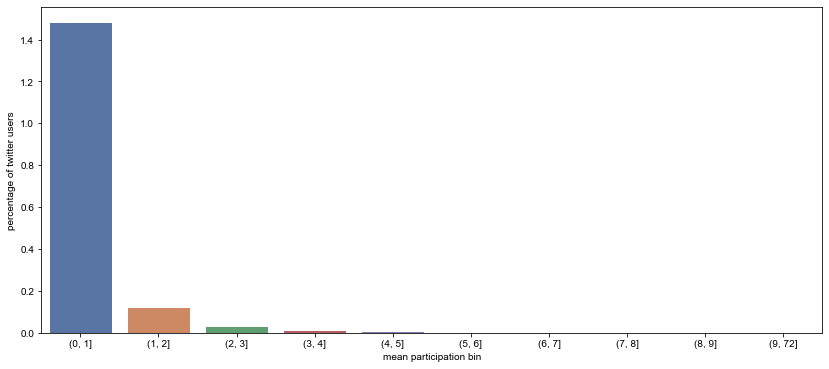

In [29]:
_, ax = plt.subplots(figsize=(14,6))
sns.set_style("whitegrid")
ax = sns.barplot(data=bin_participation, x = 'mean_par_bin', y= 'perc', palette="deep")
plt.ylabel('percentage of twitter users')
plt.xlabel('mean participation bin')

## Some Feature Extraction

In [30]:
# example of one branch 
conv = data.loc[data.conversation_id == 'dq95b41']
conv

,author,parent_id,depth,is_root,is_absolute_root,is_leaf,timestamp,conversation_id,full_conv_id,data.full_text,data.conversation_id_str,data.in_reply_to_screen_name
node_id,,,,,,,,,,,,


In [31]:
def count_op_involvment(subconv:pd.DataFrame, roots:pd.DataFrame) -> float:
    """
    counts the proportion of posts from the full conversation author in the subconversation
    """
    full_conversation_id = subconv.sample(1).full_conv_id.values[0]
    op = roots.loc[roots.full_conv_id == full_conversation_id].author.values[0]
    return len(subconv.loc[subconv.author == op]) / len(subconv)

In [32]:
# count_op_involvment(conv, roots)

ValueError: a must be greater than 0 unless no samples are taken

In [33]:
# max branch depth 
def max_branch_depth(conv:pd.DataFrame) -> int:
    return conv.depth.max()

In [34]:
max_branch_depth(conv)

nan

In [35]:
# apply two features to all of the sub-conversations 
op_involvment = data.groupby('conversation_id').apply(lambda x: count_op_involvment(x, roots))

In [36]:
op_involvment.value_counts()

0.500000    369
0.250000    339
0.333333    337
0.200000    293
0.166667    285
           ... 
0.313725      1
0.144231      1
0.004525      1
0.030000      1
0.012097      1
Length: 330, dtype: int64

In [37]:
op_involvment_ = pd.DataFrame(op_involvment).rename({0:'op_involvment'}, axis=1)
op_involvment_

,op_involvment
conversation_id,
498235547685756928,0.300000
498248415223246848,0.047619
498248648699150336,0.015625
498250100079341568,0.333333
498251940997136384,0.125000
...,...
581404604677660673,0.025641
581409613913804800,0.071429
581411131547320321,0.100000


In [38]:
feature_set = data.merge(op_involvment_, how='left', on = 'conversation_id')

## Running MAXCUT

In [98]:
def expand_classification_to_neighbors(
        interactions_graph: nx.Graph,
        start_label: bool,
        start_node: str,
        all_predicted: Tuple[List[str], List[str]],
        predicted_nodes: Set[str]
):
    for node in interactions_graph.neighbors(start_node):
            if node in predicted_nodes:
                continue

            prev_node = start_node
            label = int(start_label)
            all_predicted[label].append(node)
            neighbors = list(interactions_graph.neighbors(node))
            while len(neighbors) > 1:
                next_node = neighbors[0] if neighbors[0] != prev_node else neighbors[1]
                prev_node = node
                node = next_node
                label = 1 - label
                all_predicted[label].append(node)
                neighbors = list(interactions_graph.neighbors(node))

def expand_classification(
        interactions_graph: nx.Graph,
        supporters: Sequence[str],
        opposers: Sequence[str]
) -> Tuple[List[str], List[str]]:
    predicted_nodes = set(supporters) | set(opposers)
    all_predicted = (list(supporters), list(opposers))
    for i, group in enumerate([supporters, opposers]):
        for node in group:
            expand_classification_to_neighbors(
                interactions_graph,
                1 - i,
                node,
                all_predicted,
                predicted_nodes
            )

    return all_predicted

In [99]:
rumers_author_stance = []
for conversation in tqdm(conversations):
    reply_interactions_parser = get_reply_interactions_parser()
    interaction_graph = reply_interactions_parser.parse(conversation)
    orig_graph = interaction_graph.graph.copy()
    interaction_graph = interaction_graph.get_core_interactions(inplace=True)
    interaction_graph.set_interaction_weights(lambda x: x['replies'])
    maxcut = MaxcutStanceClassifier()
    maxcut.set_input(interaction_graph.graph)
    op = conversation.root.author
    maxcut.classify_stance(op)
    supporters = maxcut.supporters
    opposers = maxcut.complement
    supporters, opposers = expand_classification(orig_graph,
                                                 supporters,
                                                 opposers)

    for supporter in supporters:
        row = {'conversation_id': conversation.id,
               'op': conversation.op,
               'author': supporter,
               'stance': 'supporter'}
        rumers_author_stance.append(row)
    for opposer in opposers:
        row = {'conversation_id': conversation.id,
               'op': conversation.op,
               'author': opposer,
               'stance': 'opposer'}
        rumers_author_stance.append(row)

In [100]:
len(rumers_author_stance)

31034

In [101]:
user_stance_rumors = pd.DataFrame(rumers_author_stance)
user_stance_rumors

,conversation_id,op,author,stance
0,498248415223246848,14090948,14090948,supporter
1,498248415223246848,14090948,19313747,supporter
2,498248415223246848,14090948,977432202,opposer
3,498248415223246848,14090948,14238795,opposer
4,498248415223246848,14090948,105357244,opposer
...,...,...,...,...
31029,581409613913804800,5392522,240391453,opposer
31030,581409613913804800,5392522,135160732,opposer
31031,581409613913804800,5392522,2179058990,opposer
31032,581409613913804800,5392522,94926215,opposer


In [102]:
user_stance_rumors.dtypes

conversation_id    object
op                 object
author             object
stance             object
dtype: object

In [103]:
user_stance_rumors.conversation_id.nunique()

773

## Gold Standard

In [104]:
def load_annotations(annotations_path: str) -> Iterable[dict]:
    with open(annotations_path, 'r') as f:
        for line in f:
            if line.startswith("{"):
                ann = json.loads(line)
                if "responsetype-vs-source" in ann:
                    yield ann

In [105]:
path = r"C:\Users\ronp\Documents\stance-classification\rumors_dataset\pheme-rumour-scheme-dataset\annotations\en-scheme-annotations.json"
# path = "/Users/shaimeital/code/thesis/cmv-stance-classification/Examples/en-scheme-annotations_clean.jsonl"

annotations = load_annotations(path)
rumors_gold_label = pd.DataFrame.from_records(annotations)
rumors_gold_label


,event,threadid,tweetid,responsetype-vs-source,certainty,evidentiality,responsetype-vs-previous
0,putinmissing,577258317942149120,577260238316830721,comment,NaN,NaN,NaN
1,putinmissing,577258317942149120,577282462788677634,comment,NaN,NaN,NaN
2,putinmissing,577258317942149120,577283431089901568,comment,NaN,NaN,NaN
3,putinmissing,577258317942149120,577284294051123201,comment,NaN,NaN,NaN
4,putinmissing,577258317942149120,577287160329465856,comment,NaN,NaN,NaN
...,...,...,...,...,...,...,...
4258,ebola-essien,521346721226711040,521371539082858496,comment,NaN,NaN,comment
4259,ebola-essien,521346721226711040,521371742942797825,comment,NaN,NaN,comment
4260,ebola-essien,521346721226711040,521353434881327104,comment,NaN,NaN,comment
4261,ebola-essien,521346721226711040,521366121484918785,disagreed,uncertain,no-evidence,comment


In [106]:
rumors_gold_label['responsetype-vs-source'].value_counts()

comment                        2923
agreed                          645
appeal-for-more-information     361
disagreed                       334
Name: responsetype-vs-source, dtype: int64

In [107]:
rumors_gold_label = rumors_gold_label.filter(['threadid', 'tweetid', 'responsetype-vs-source'], axis=1).rename({'responsetype-vs-source': 'label'}, axis=1)
rumors_gold_label

,threadid,tweetid,label
0,577258317942149120,577260238316830721,comment
1,577258317942149120,577282462788677634,comment
2,577258317942149120,577283431089901568,comment
3,577258317942149120,577284294051123201,comment
4,577258317942149120,577287160329465856,comment
...,...,...,...
4258,521346721226711040,521371539082858496,comment
4259,521346721226711040,521371742942797825,comment
4260,521346721226711040,521353434881327104,comment
4261,521346721226711040,521366121484918785,disagreed


In [108]:
rumors_gold_label.threadid = rumors_gold_label.threadid.astype('str') 

In [109]:
rumors_gold_label.tweetid = rumors_gold_label.tweetid.astype('str') 

In [110]:
rumors_gold_label.dtypes

threadid    object
tweetid     object
label       object
dtype: object

In [111]:
twitter_convs = convs.copy()
twitter_convs = twitter_convs.reset_index().rename({
    "full_conv_id": "threadid",
    "node_id": "tweetid"
}, axis=1)
twitter_convs

,tweetid,author,parent_id,depth,is_root,is_absolute_root,is_leaf,timestamp,conversation_id,threadid,data.full_text,data.conversation_id_str,data.in_reply_to_screen_name
0,498235547685756928,1539100118,None,0,True,True,False,1.407624e+09,498235547685756928,498235547685756928,[Black teenage boys are not men. They are chil...,[498235547685756928],[nan]
1,498265524397432832,21461995,498235547685756928,1,False,False,True,1.407631e+09,498235547685756928,498235547685756928,"[@annaxsweat http://t.co/Z7Qm4iaoSR, @annaxswe...","[498235547685756928, 498235547685756928]","[annaxsweat, annaxsweat]"
2,498710112358244352,481509183,498235547685756928,1,False,False,False,1.407737e+09,498235547685756928,498235547685756928,[@annaxsweat 18*],[498235547685756928],[annaxsweat]
3,498785502062190592,1539100118,498710112358244352,2,False,False,True,1.407755e+09,498235547685756928,498235547685756928,[@AlexisAStevens yeah that tweet was written b...,[498235547685756928],[AlexisAurora_]
4,498519407375941632,2331498373,498235547685756928,1,False,False,True,1.407691e+09,498235547685756928,498235547685756928,[@annaxsweat: Soooo wonderfully said! Thank yo...,[498235547685756928],[annaxsweat]
...,...,...,...,...,...,...,...,...,...,...,...,...,...
98811,581473907275915264,1895019528,581473088249958400,1,False,False,True,1.427469e+09,581473088249958400,581473088249958400,[@jjauthor @gatewaypundit terrorism],[581473088249958400],[jjauthor]
98812,581474582302949376,2983617889,581473088249958400,1,False,False,True,1.427469e+09,581473088249958400,581473088249958400,[@jjauthor @gatewaypundit Hmmm.Doesn't pundit ...,[581473088249958400],[jjauthor]
98813,581473799398359040,2920578401,581473088249958400,1,False,False,True,1.427469e+09,581473088249958400,581473088249958400,[@jjauthor @gatewaypundit. I knew it! Those cr...,[581473088249958400],[jjauthor]
98814,581482916645076993,373569258,581473088249958400,1,False,False,True,1.427471e+09,581473088249958400,581473088249958400,[@jjauthor @DesireeAaron @gatewaypundit this i...,[581473088249958400],[jjauthor]


In [112]:
convs_a = twitter_convs.filter(['threadid', 'tweetid', 'author'], axis=1)
convs_a

,threadid,tweetid,author
0,498235547685756928,498235547685756928,1539100118
1,498235547685756928,498265524397432832,21461995
2,498235547685756928,498710112358244352,481509183
3,498235547685756928,498785502062190592,1539100118
4,498235547685756928,498519407375941632,2331498373
...,...,...,...
98811,581473088249958400,581473907275915264,1895019528
98812,581473088249958400,581474582302949376,2983617889
98813,581473088249958400,581473799398359040,2920578401
98814,581473088249958400,581482916645076993,373569258


In [113]:
convs_a.dtypes

threadid    object
tweetid     object
author      object
dtype: object

In [114]:
rumors_gold_label_ = rumors_gold_label.merge(convs_a, how = 'left', on=['threadid', 'tweetid'])
rumors_gold_label_

,threadid,tweetid,label,author
0,577258317942149120,577260238316830721,comment,NaN
1,577258317942149120,577282462788677634,comment,NaN
2,577258317942149120,577283431089901568,comment,NaN
3,577258317942149120,577284294051123201,comment,NaN
4,577258317942149120,577287160329465856,comment,NaN
...,...,...,...,...
4258,521346721226711040,521371539082858496,comment,NaN
4259,521346721226711040,521371742942797825,comment,NaN
4260,521346721226711040,521353434881327104,comment,466457803
4261,521346721226711040,521366121484918785,disagreed,NaN


In [115]:
rumors_gold_label_.author.isna().sum()

2180

In [116]:
rumors_gold_label_nona = rumors_gold_label_.dropna()
rumors_gold_label_nona

,threadid,tweetid,label,author
5,576755174531862529,576755963597746176,comment,376884268
7,576755174531862529,576758668026245120,appeal-for-more-information,5469742
8,576319832800555008,576321273594294272,comment,1946971338
10,576319832800555008,576321856166346752,disagreed,2406844921
12,576319832800555008,576327925869506560,appeal-for-more-information,138681055
...,...,...,...,...
4219,524932935137628160,524940370321629184,comment,37632713
4253,521346721226711040,521367394108071936,agreed,2747372070
4254,521346721226711040,521367905062379521,disagreed,430026970
4255,521346721226711040,521368022880378882,comment,2747372070


In [117]:
user_stance_rumors = user_stance_rumors.rename({'conversation_id': 'threadid', 'stance':'stance_prediction'}, axis=1)
user_stance_rumors

,threadid,op,author,stance_prediction
0,498248415223246848,14090948,14090948,supporter
1,498248415223246848,14090948,19313747,supporter
2,498248415223246848,14090948,977432202,opposer
3,498248415223246848,14090948,14238795,opposer
4,498248415223246848,14090948,105357244,opposer
...,...,...,...,...
31029,581409613913804800,5392522,240391453,opposer
31030,581409613913804800,5392522,135160732,opposer
31031,581409613913804800,5392522,2179058990,opposer
31032,581409613913804800,5392522,94926215,opposer


In [118]:
predictions = user_stance_rumors.merge(rumors_gold_label_nona, how='left', on = ['threadid', 'author'])
predictions

,threadid,op,author,stance_prediction,tweetid,label
0,498248415223246848,14090948,14090948,supporter,NaN,NaN
1,498248415223246848,14090948,19313747,supporter,NaN,NaN
2,498248415223246848,14090948,977432202,opposer,NaN,NaN
3,498248415223246848,14090948,14238795,opposer,NaN,NaN
4,498248415223246848,14090948,105357244,opposer,NaN,NaN
...,...,...,...,...,...,...
31141,581409613913804800,5392522,240391453,opposer,NaN,NaN
31142,581409613913804800,5392522,135160732,opposer,NaN,NaN
31143,581409613913804800,5392522,2179058990,opposer,NaN,NaN
31144,581409613913804800,5392522,94926215,opposer,NaN,NaN


In [119]:
predictions_ = predictions.dropna()
predictions_

,threadid,op,author,stance_prediction,tweetid,label
660,498430783699554305,24165761,571796080,supporter,498504798971650049,comment
662,498430783699554305,24165761,402355096,supporter,498451864112074752,comment
663,498430783699554305,24165761,277170191,supporter,498488174923227136,agreed
664,498430783699554305,24165761,61934810,opposer,498440508256292864,comment
665,498430783699554305,24165761,798151213,opposer,498432131669192704,comment
...,...,...,...,...,...,...
30265,580319078155468800,5402612,2551443991,supporter,580337415241383938,comment
30266,580319078155468800,5402612,2551443991,supporter,580337829638598656,comment
30269,580319078155468800,5402612,59162656,opposer,580320979995508737,agreed
30270,580319078155468800,5402612,59162656,opposer,580333804457496576,comment


In [120]:
predictions_.loc[(predictions_.stance_prediction == 'supporter') & (predictions_.label == 'agreed') ]

,threadid,op,author,stance_prediction,tweetid,label
663,498430783699554305,24165761,277170191,supporter,498488174923227136,agreed
4344,500286058664579072,972651,2423249816,supporter,500290256928014336,agreed
4606,500290456845299714,1363520268,84887951,supporter,500298596772622336,agreed
7006,500389488217309184,15996661,935922770,supporter,500476059880816640,agreed
10400,529720273285566464,21137035,55121758,supporter,529721379302952961,agreed
11635,544306719686656000,14460241,316364374,supporter,544309297480364032,agreed
28243,553508098825261056,14173315,324658179,supporter,553541311484014592,agreed
29308,553576010898497536,3108351,2208746299,supporter,553577770983645186,agreed


In [121]:
predictions_.loc[(predictions_.stance_prediction == 'opposer') & (predictions_.label == 'disagreed') ]

,threadid,op,author,stance_prediction,tweetid,label
4355,500286058664579072,972651,14227485,opposer,500289420730597377,disagreed
4362,500286058664579072,972651,1455101366,opposer,500287325621198848,disagreed
4399,500286058664579072,972651,27730063,opposer,500287363361546240,disagreed
5219,500308076004929537,1363520268,30715785,opposer,500313313188663296,disagreed
6772,500377145349521411,14464766,423321195,opposer,500386025412104192,disagreed
6780,500377145349521411,14464766,48463755,opposer,500386677513154560,disagreed
7013,500389488217309184,15996661,353984748,opposer,500407103774003201,disagreed
7028,500389488217309184,15996661,416009248,opposer,500390996673585152,disagreed
11037,544288681021145090,16973333,2177175701,opposer,544290393693904896,disagreed
13986,544399927045283840,5402612,176310317,opposer,544557233455910913,disagreed


In [122]:
predictions_.loc[(predictions_.stance_prediction == 'supporter') & (predictions_.label == 'disagreed') ]

,threadid,op,author,stance_prediction,tweetid,label
5210,500308076004929537,1363520268,1363520268,supporter,500318691909959681,disagreed
19633,552805488631758849,428333,2707815410,supporter,552816281737363458,disagreed
19647,552805488631758849,428333,2926384805,supporter,553556666969763841,disagreed


In [123]:
predictions_.loc[(predictions_.stance_prediction == 'opposer') & (predictions_.label == 'agreed') ]

,threadid,op,author,stance_prediction,tweetid,label
4611,500290456845299714,1363520268,796814947,opposer,500297973905895424,agreed
6774,500377145349521411,14464766,69878030,opposer,500379102353047553,agreed
6776,500377145349521411,14464766,74324914,opposer,500387923372425216,agreed
6781,500377145349521411,14464766,45218962,opposer,500379602435731456,agreed
7009,500389488217309184,15996661,164753964,opposer,500390975819513856,agreed
7010,500389488217309184,15996661,2724282976,opposer,500472734573658112,agreed
7021,500389488217309184,15996661,2732777130,opposer,500395857473466368,agreed
10419,529720273285566464,21137035,1262935440,opposer,529723695989002241,agreed
10436,529720273285566464,21137035,15657577,opposer,529721009172410369,agreed
11019,544287209730236416,1855737487,20952653,opposer,544292469866000387,agreed


## Extra for TSNE + PCA

In [124]:
# data = pd.DataFrame.from_records(features, index="conv_id")
# print(data.head())

In [125]:
data_ = data.loc[data.num_nodes > 10]

AttributeError: 'DataFrame' object has no attribute 'num_nodes'

In [126]:
data_.count()

NameError: name 'data_' is not defined

In [127]:
data_

NameError: name 'data_' is not defined

In [128]:
data_.describe()

NameError: name 'data_' is not defined

In [129]:
data_ = data_.fillna(0)

NameError: name 'data_' is not defined

In [130]:
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler


In [131]:
standardized_data = StandardScaler().fit_transform(data_)
print(standardized_data.shape)

NameError: name 'data_' is not defined

In [ ]:
model = TSNE(n_components=2, random_state=0)

In [ ]:
tsne_data = model.fit_transform(standardized_data)

In [ ]:
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2"))

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
sns.FacetGrid(tsne_df, height=9).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.show()

In [ ]:
from sklearn.cluster import DBSCAN


In [ ]:
m = DBSCAN()


In [ ]:
m.fit(standardized_data)

In [ ]:
clusters = m.labels_

In [ ]:
pd.Series(clusters).value_counts()

In [ ]:
# pca

from sklearn.decomposition import PCA


In [ ]:
pca = PCA(n_components=2)


In [ ]:
principalComponents = pca.fit_transform(standardized_data)

In [ ]:
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2'])

In [ ]:
sns.FacetGrid(principalDf, height=6).map(plt.scatter, 'principal component 1', 'principal component 2').add_legend()
plt.show()